In [1]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
os.chdir('/Users/vprud/Work/spikennet')
os.getcwd()

'/Users/vprud/Work/spikennet'

In [3]:
from spikennet.utils.dataset import ExpData
from spikennet.utils.prepare import gen_folds
from spikennet.models import SpikeDNNet, IzhikevichAF, SigmoidAF
from spikennet.utils.plot import plot_experiment, plot_article

In [4]:
KEY_INDEX = 1
M_FOLDS = 1
DIM = 2

K = 220
SCALER = 3

### Подготовка датасета

In [5]:
exp_data = ExpData('data_132591818490899344_.txt')
exp_data.prep()
data = exp_data.get_data(KEY_INDEX)

In [6]:
folds, width, split = gen_folds(data, n_folds=M_FOLDS)
time = np.linspace(0, width, width)

### Обучение дифференциальной нейросети

In [7]:
act_izh = IzhikevichAF(dim=DIM)
act_sig = SigmoidAF()

mdls_config = {
    'izhikevich': {
        'act_func_1': act_izh.map,
        'act_func_2': act_izh.map,
        'dim': DIM,
        'mat_A': 20 * np.diag([-1, -2]),
        'mat_P': 1575.9 * np.diag([60, 40]),
        'mat_K_1': 0.15 * np.diag([10, 1]),
        'mat_K_2': 0.15 * np.diag([1, 1]),
        'mat_W_1': 20 * np.ones((DIM, DIM)),
        'mat_W_2': 20 * np.ones((DIM, DIM))
    },
    'sigmoidal': {
        'act_func_1': act_sig.map,
        'act_func_2': act_sig.map,
        'dim': DIM,
        'mat_A': 20 * np.diag([-2, -2]),
        'mat_P': 1575.9 * np.diag([60, 40]),
        'mat_K_1': 0.0001 * np.diag([20, 10]),
        'mat_K_2': 0.0001 * np.diag([20, 10]),
        'mat_W_1': 0.1 * np.ones((DIM, DIM)),
        'mat_W_2': 20 * np.ones((DIM, DIM))
        },
    'hybryd': {
        'act_func_1': act_izh.map,
        'act_func_2': act_sig.map,
        'dim': DIM,
        'mat_A': 30 * np.diag([-1, -2]),
        'mat_P': 1575.9 * np.diag([60, 40]),
        'mat_K_1': 0.0001 * np.diag([20, 10]),
        'mat_K_2': 0.1 * np.diag([1, 1]),
        'mat_W_1': 20 * np.ones((DIM, DIM)),
        'mat_W_2': 20 * np.ones((DIM, DIM))
    },
}

dnn = SpikeDNNet(**mdls_config['izhikevich'])

In [8]:
# 173 ms ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
start = 6 * 110
end = int(11.2 * 110)

for i, fold in enumerate(folds):
    tr_target = fold[0][0]
    tr_control = fold[0][1]

    vl_target = fold[1][0]
    vl_control = fold[1][1]
        
    tr_target = (tr_target - SCALER*np.mean(tr_target))
    est_SDNN = dnn.fit(tr_target[start:end], tr_control[start:end], n_epochs=1)
    
init = est_SDNN[-2:-1, :]
pred_SDNN = dnn.predict(init, tr_control[end:end+K])

### Обучение линейной регрессии

In [9]:
tmp = pd.DataFrame(data={'LeftYaw': tr_target[:,0], 'RotAngleY': tr_control[:,0]})

prevs = tmp[['LeftYaw', 'RotAngleY']].shift(1).rename(columns={'LeftYaw': 'prev_LeftYaw', 'RotAngleY': 'prev_RotAngleY'})
diffs = tmp[['LeftYaw', 'RotAngleY']].diff().rename(columns={'LeftYaw': 'diff_LeftYaw', 'RotAngleY': 'diff_RotAngleY'})

lr_data = pd.concat([tmp[['LeftYaw', 'RotAngleY']], prevs, diffs], axis=1).dropna()

train_feats = lr_data[['prev_LeftYaw', 'prev_RotAngleY']]
train_target = lr_data[['LeftYaw']]

In [10]:
# 1.56 ms ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
def reg_(x1, x2, r):
    return (r.coef_[0][0]*x1 - SCALER*r.coef_[0][1]*x2)

reg = LinearRegression()

reg.fit(train_feats[end:end+K], train_target[end:end+K])
est_Reg = reg.predict(train_feats[start:end]).flatten()


pred_Reg = []
pred = est_Reg[-1]

for c in tr_control[end:end+K,0]:
    pred = reg_(pred, c, reg)
    #print("delta", delta)
    pred_Reg.append(pred)

### Обучение статической нейросети с LSTM-слоем

In [11]:
training_set = tr_target[:,0].reshape(len(tr_target),-1)
training_set = tr_control[:,0].reshape(len(tr_control),-1)

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)


seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[start:end])))
trainY = Variable(torch.Tensor(np.array(y[start:end])))

testX = Variable(torch.Tensor(np.array(x[end:end+K])))
testY = Variable(torch.Tensor(np.array(y[end:end+K])))

In [12]:
target = tr_target[:,0].reshape(len(tr_target), -1)
control = tr_control[:,0].reshape(len(tr_control), -1)

def sliding_windows_combine(control, target, seq_length, sdl):
    x = []
    y = []

    for i in range(len(control)-seq_length-1):
        _c = control[i+sdl:i+seq_length]
        _t = target[i+sdl:i+seq_length]
        
        _x = np.concatenate((_c, _t), dtype=np.float32)
        #_x = control[i:(i+seq_length)]
        _y = target[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

sc_target = MinMaxScaler()
sc_control = MinMaxScaler()

lr_target = sc_target.fit_transform(target)
lr_control = sc_control.fit_transform(control)


seq_length = 10
sdl = 5
x, y = sliding_windows_combine(lr_control, lr_target, seq_length, sdl)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

sl = 10
trainX = Variable(torch.Tensor(np.array(x[end:end+K])))
trainY = Variable(torch.Tensor(np.array(y[end:end+K])))

testX = Variable(torch.Tensor(np.array(x[end+K:end+2*K])))
testY = Variable(torch.Tensor(np.array(y[end+K:end+2*K])))

In [13]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [14]:
# 3.34 s ± 192 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.55101
Epoch: 100, loss: 0.02556
Epoch: 200, loss: 0.00242
Epoch: 300, loss: 0.00111
Epoch: 400, loss: 0.00110
Epoch: 500, loss: 0.00109
Epoch: 600, loss: 0.00109
Epoch: 700, loss: 0.00109
Epoch: 800, loss: 0.00109
Epoch: 900, loss: 0.00109


In [15]:
lstm.eval()

train_predict = lstm(dataX)

est_LSTM = train_predict.data.numpy()
est_LSTM = sc_target.inverse_transform(est_LSTM)
est_LSTM = est_LSTM.flatten()

In [16]:
trainX.shape

torch.Size([220, 10, 1])

In [17]:
lstm.eval()

pred = lstm(trainX[-3:-1])[0]

pred_LSTM = []
#pred = est_LSTM[-1]

_c = trainX[-1][:sdl]
_t = trainX[-1][sdl:seq_length]
cnt = 0

for c in tr_control[end:end+K,0]:
    cnt += 1
    pred = reg_(pred, c, reg)

    c = torch.tensor(sc_control.transform([[c]]))
    _c = torch.cat((_c[1:], c))
    
    t = torch.tensor([[pred]])
    _t = torch.cat((_t[1:], t))
    
    _x = torch.cat((_c, _t))
    _x = torch.unsqueeze(_x, dim=0)
    _x = _x.to(torch.float32)
    
    pred = lstm(_x)
    
    pred_val = pred.detach().numpy()[0][0]
    
    pred_LSTM.append(pred_val)

In [18]:
pred_LSTM = sc_target.inverse_transform([pred_LSTM])[0]

### Сравнение моделей

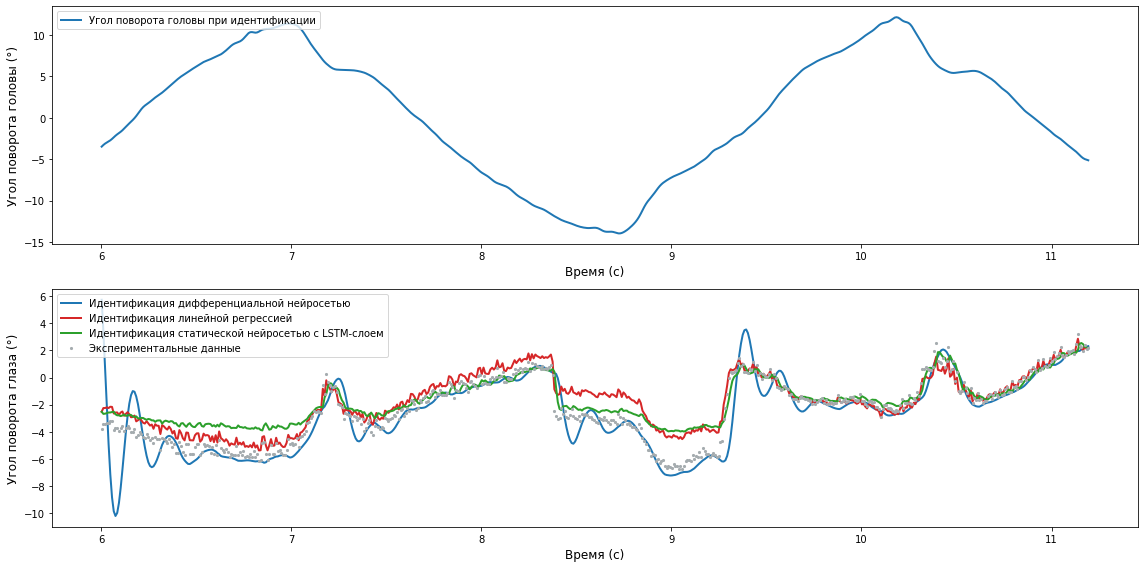

In [19]:
fig, axs = plt.subplots(2, figsize=(16, 8))

axs[0].plot(time[start:end] / 110,
               np.degrees(tr_control[start:end, 0]),
               color='tab:blue',
               lw='2')

axs[1].scatter(time[start:end] / 110,
                  np.degrees(tr_target[start:end, 0]) ,
                  linestyle='solid',
                  color=(165/255, 172/255, 175/255),
                  s=4.5,
                  zorder=100)

axs[1].plot(time[start:end] / 110,
               np.degrees(est_SDNN[:, 0]),
               color='tab:blue',
               lw='2')

axs[1].plot(time[start:end] / 110,
               np.degrees(est_Reg[:]) ,
               color='tab:red',
               lw='2')

axs[1].plot(time[start:end] / 110,
               np.degrees(est_LSTM[start-seq_length:end-seq_length]),
               color='tab:green',
               lw='2')

if False:
    axs[1].plot(time[end:end+K] / 110,
                   np.degrees(pred_SDNN[:, 0]+0.025),
                   color='tab:blue',
                   linestyle='dashed',
                   lw='2')

    axs[1].plot(time[end:end+K] / 110,
                   np.degrees(pred_Reg[:]) ,
                   color='tab:red',
                   linestyle='dashed',
                   lw='2')
    
    
    axs[1].plot(time[end:end+K] / 110,
                   np.degrees(-1*pred_LSTM[:]+2*est_LSTM[end-seq_length]) ,
                   color='tab:green',
                   linestyle='dashed',
                   lw='2')
    
    axs[1].scatter(time[end:end+K] / 110,
                  np.degrees(tr_target[end:end+K, 0]),
                  linestyle='solid',
                  color=(165/255, 172/255, 175/255),
                  s=4.5,
                  zorder=100)
    
    axs[0].plot(time[end:end+K] / 110,
                np.degrees(tr_control[end:end+K]),
                color='tab:orange',
                linestyle='dashed',
                lw='2')
    
    axs[1].legend(['Обучение дифференциальной нейросети',
                   'Обучение линейной регрессии',
                   'Обучение статической нейросети с LSTM-слоем',
                   'Предсказание модели Ижикевича',
                   'Предсказание линейной регрессии',
                   'Предсказание статической нейросети с LSTM-слоем',
                   'Экспериментальные данные'],
                  loc='upper left')
    
    axs[0].legend(['Угол поворота головы при обучении',
                   'Угол поворота головы при прогнозировании'],
                  loc='upper left')
    
    axs[0].axvline(x=[11.2],
                      ymin=0.97,
                      ymax=0.994838,
                      c=(65/255, 65/255, 65/255),
                      linewidth=2,
                      zorder=0,
                      linestyle=(0, (5, 10)),
                      clip_on=False)

    axs[1].axvline(x=[11.2],
                      ymin=0.0,
                      ymax=2.1,
                      c=(65/255, 65/255, 65/255),
                      linewidth=2,
                      zorder=100,
                      linestyle=(0, (5, 10)),
                      clip_on=False)
else:
    
    axs[0].legend(['Угол поворота головы при идентификации'],
                  loc='upper left')
    
    axs[1].legend(['Идентификация дифференциальной нейросетью',
                   'Идентификация линейной регрессией',
                   'Идентификация статической нейросетью с LSTM-слоем',
                   'Экспериментальные данные'],
                  loc='upper left')

axs[0].set_xlabel('Время (с)', fontsize=12)
axs[1].set_xlabel('Время (с)', fontsize=12)

axs[0].set_ylabel('Угол поворота головы (°)', fontsize=12)
axs[1].set_ylabel('Угол поворота глаза (°)', fontsize=12)


plt.tight_layout()
plt.savefig('./report/comparing_plus_iden.pdf')

In [20]:
trains = tr_target[start:end, 0]


est_SDNN_ = est_SDNN[:, 0]
est_Reg_ = est_Reg[:]
est_LSTM_ = est_LSTM[start-seq_length:end-seq_length]

ests = {'SDNN': est_SDNN_, 
        'LinReg': est_Reg_,
        'LSTM': est_LSTM_}

In [21]:
for label in ests:
    
    e = ests[label]
    #print(type(e), type())
    mse = mean_squared_error(trains, e)
    mae = mean_absolute_error(trains, e)
    smae = mae / np.mean(trains)

    print("""
    Model name: {}
         MSE: {:2.6f}
         MAE: {:2.6f}
        sMAE: {:2.6f}
        """.format(label, mse, mae, smae))


    Model name: SDNN
         MSE: 0.000474
         MAE: 0.013322
        sMAE: -0.334681
        

    Model name: LinReg
         MSE: 0.000275
         MAE: 0.012300
        sMAE: -0.309003
        

    Model name: LSTM
         MSE: 0.000355
         MAE: 0.013902
        sMAE: -0.349271
        
